# Introduction
- pytorch の使い方を簡単に説明します。
- より詳しいチュートリアルは、公式がおすすめです。
 >  https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
 

# Let's import everything we need :)

In [8]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Function

In [9]:
def grad_plot(x, y, x_list, y_list):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    axs = axs.ravel()
    axs[0].plot(_x, _y)
    axs[0].plot(x_list, y_list, '-o', alpha=0.5, color='orange')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].set_title('quadratic function')
    axs[1].plot(grad_list)
    axs[1].plot(grad_list, markerfacecolor='orange', marker='o', markeredgecolor='orange', alpha=0.5, lw=0)
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('gradient')
    axs[1].set_title('gradient')
#     fig.show()

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Pytorch tutorial
- ニューラルネットワークは、多くのパラメータを扱います。その多くのパラメータをデータに最適化することを学習と呼びます。
- 本例は、学習が行われている時内部で何が行われているのかを理解するために作成しました。

In [24]:
# 例の前に実行結果が変わらないように、seedを固定します
seed_torch(0)

## 2次関数

2次関数を損失関数と考えてその最小値を求めてみます。  
問題設定としては、以下のようになります。  
- 二次関数y を最小とするようなxの値はなにか？

<br>
以下で解いていきます。

In [11]:
# init
x_init = 10
n_epoch = 30
lr = 0.1  # learning_rate

# 初期値を定義
x = torch.tensor([float(x_init)], requires_grad=True)
x_list = []
grad_list = []

for epoch in range(n_epoch):
    y = x**2      # このyを最小化したい
    y.backward()  # 現在のxでの傾きを計算
    x_list.append(float(x))  # 現在のxを格納
    grad_list.append(float(x.grad)) # 計算した傾きを格納

    # パラメータ(x) の更新
    with torch.no_grad():
        x = x - lr*x.grad  # lr が大きいほど大きく値を更新する
    x.requires_grad = True

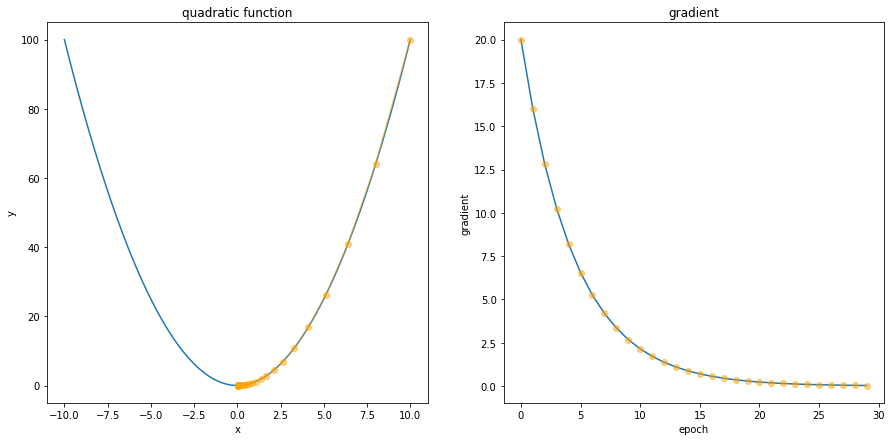

In [12]:
# plot
_x = np.arange(-x_init, x_init+0.01, 0.01)
_y = _x**2
x_list = np.array(x_list)
y_list = x_list**2
grad_plot(_x, _y, x_list, y_list)

---> パラメータxが更新されるたびに、y(損失関数)が小さくなっていることがわかります。  
---> ちなみに、パラメータの更新には最もシンプルな `勾配法` 使用しました。

<br>

## 4次関数

次は、2次関数と同様に4次関数でも最小値を探してみたいと思います。

In [13]:
def quartic_function(x):
    return x**4 - 12*x**2 + 10*x 

In [14]:
# init
x_init = 5
n_epoch = 150
lr = 0.001  # learning_rate

# 初期値を定義
x = torch.tensor([float(x_init)], requires_grad=True)
x_list = []
grad_list = []

# train
for epoch in range(n_epoch):
    y = quartic_function(x) 
    y.backward()
    x_list.append(float(x))
    grad_list.append(float(x.grad))
    
    # パラメータ(x)更新(更新方法は勾配法)
    with torch.no_grad():
        x = x - lr*x.grad
    x.requires_grad = True

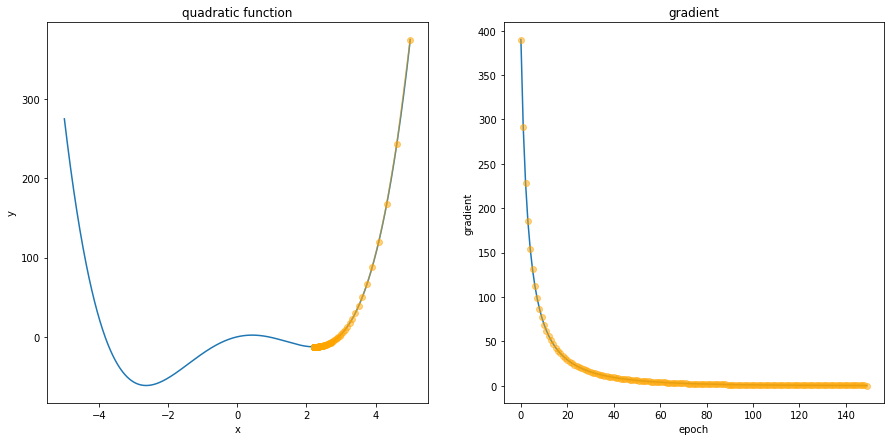

In [15]:
# plot
_x = np.arange(-x_init, x_init+0.01, 0.01)
_y = quartic_function(_x)
x_list = np.array(x_list)
y_list = quartic_function(x_list)

grad_plot(_x, _y, x_list, y_list)

---> 勾配法だとローカルミニマムに落ちてそれ以上変化していないことがわかると思います。  
---> パラメータの更新方法を変えてみます。(今度は、pytorchの `optimizer` を使います。)

- 更新方法がAdam だと?

In [16]:
# init
x_init = 5
n_epoch = 150
lr = 0.5  # learning_rate

# 初期値を定義
x = torch.tensor([float(x_init)], requires_grad=True)
x_list = []
grad_list = []
optimizer = torch.optim.Adam([x], lr=lr)

# train
for epoch in range(n_epoch):
    optimizer.zero_grad()
    y = quartic_function(x)  # 4次関数(y) を最小化したい
    y.backward()             # 現在のxにおける傾き(dy/dx) を計算
    x_list.append(float(x)) 
    grad_list.append(float(x.grad))
    
    # パラメータ(x)更新(更新方法はAdam)
    optimizer.step()

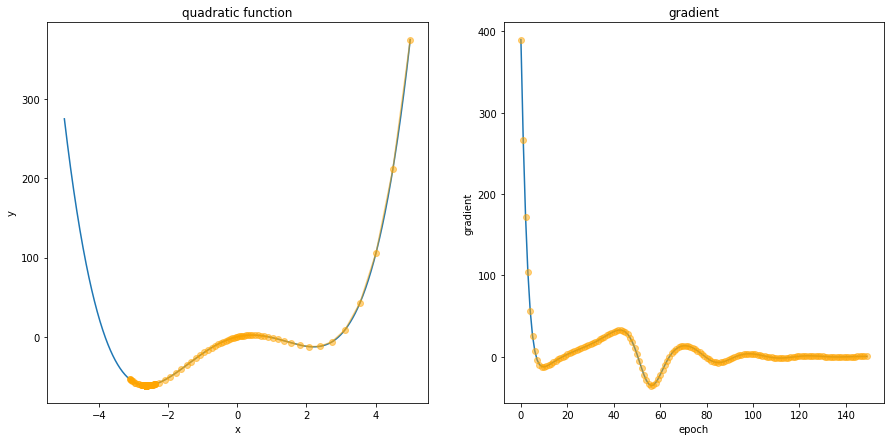

In [17]:
# plot
_x = np.arange(-x_init, x_init+0.01, 0.01)
_y = quartic_function(_x)
x_list = np.array(x_list)
y_list = quartic_function(x_list)

grad_plot(_x, _y, x_list, y_list)

---> いい感じ!! `Adam` の解説については、ググってください。  
---> ニューラルネットワークも同様に損失関数の勾配情報を元にパラメータを更新します。   
---> この後、ニューラルネットワークの例を用いますが、`y --> criterion(損失関数)`、`x --> ニューロンのパラメータ` と対応させれば同様な問題と考えることができます。  

<br>
<br>

## NewralNetwork

いよいよ、pytorch を使ったニューラルネットワークの学習方法について学びます。  
ネットワークの書き方には大きくわけて3つの流儀があり、今回はコンストラクタにネットワークの構造をすべて書く方法を用いました。  
参考: http://nobunaga.hatenablog.jp/entry/2018/09/23/171149

今回作成するネットワークは、とてもシンプルで入力層、隠れ層、出力層の数がそれぞれ1となっています。

<img src='080/newral_net.png' width='400'>

<br>

データは iris データ・セットを使用します。データの30%を検証用に使います。

In [18]:
iris = load_iris()
target = iris.target
feat_name = iris.feature_names
df = pd.DataFrame(iris.data, columns=feat_name)

In [19]:
y = np.zeros((len(iris.target), 1 + iris.target.max()), dtype=int)
y[np.arange(len(iris.target)), iris.target] = 1
X = df.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=1)

<br>

モデルの定義

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 5)  # input 4次元, output: 5次元
        self.ac1 = nn.ReLU()
        self.fc2 = nn.Linear(5, 3)

    def forward(self, x):
        x = self.ac1(self.fc1(x))
        x = self.fc2(x)
        return x

<br>

データをpytorch用に変換します。  
(今回は使いませんが)gpuで計算させるために必要な手続きです。

In [21]:
X_train_pt = Variable(torch.from_numpy(X_train).float(), requires_grad=True)
y_train_pt = Variable(torch.from_numpy(y_train).float())
y_valid_pt = Variable(torch.from_numpy(y_valid).float())

<br>

学習、検証

In [25]:
%%time

net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.MSELoss()
loss_valid_list = []
loss_train_list = []

n_epoch = 10000
for i in range(n_epoch):
    optimizer.zero_grad()
    output = net(X_train_pt)
    loss = criterion(output, y_train_pt)
    loss.backward()
    optimizer.step()
    
    output_val = net(Variable(torch.from_numpy(X_valid).float()))
    loss_valid = criterion(output_val, y_valid_pt)
    loss_valid_list.append(loss_valid.item())
    loss_train_list.append(loss.item())

CPU times: user 3.61 s, sys: 145 ms, total: 3.76 s
Wall time: 3.75 s


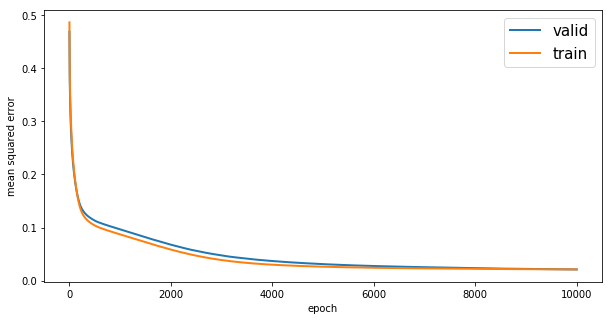

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(loss_valid_list, label='valid', lw=2)
plt.plot(loss_train_list, label='train', lw=2)
plt.xlabel('epoch')
plt.ylabel('mean squared error')
plt.legend(fontsize=15)

---

<br>

以下を行ってください

1. 入力層、出力層がノード数がそれぞれ 4個,3個である理由を書いてください。  
2. 下記に上のプログラムをコピーしたコードがあります。これを改良して100epoch毎にtrainとvalidデータのaccuracyを計算し、横軸epoch、縦軸accuracyのグラフを書いてください。

<br>

1

<br>

2

In [62]:
%%time

net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.MSELoss()
loss_valid_list = []
loss_train_list = []

n_epoch = 10000
for i in range(n_epoch):
    optimizer.zero_grad()
    output = net(X_train_pt)
    loss = criterion(output, y_train_pt)
    loss.backward()
    optimizer.step()
    
    output_val = net(Variable(torch.from_numpy(X_valid).float()))
    loss_valid = criterion(output_val, y_valid_pt)
    loss_valid_list.append(loss_valid.item())
    loss_train_list.append(loss.item())

CPU times: user 2.52 s, sys: 89.7 ms, total: 2.61 s
Wall time: 2.59 s
